In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!ls /content/drive/MyDrive/Resultats/Timewarp

ls: cannot access '/content/drive/MyDrive/Resultats/Timewarp': Input/output error


In [ ]:
!pip install -q condacolab
import condacolab
condacolab.install()


!mamba install -c conda-forge openmmforcefields -y
!mamba install -c conda-forge openmm parmed nglview pdbfixer -y

✨🍰✨ Everything looks OK!

Looking for: ['openmmforcefields']

conda-forge/linux-64                                        Using cache
conda-forge/noarch                                          Using cache

Pinned packages:
  - python 3.11.*
  - python 3.11.*
  - python_abi 3.11.* *cp311*
  - cuda-version 12.*


Transaction

  Prefix: /usr/local

  All requested packages already installed


Looking for: ['openmm', 'parmed', 'nglview', 'pdbfixer']

conda-forge/linux-64                                        Using cache
conda-forge/noarch                                          Using cache

Pinned packages:
  - python 3.11.*
  - python 3.11.*
  - python_abi 3.11.* *cp311*
  - cuda-version 12.*


Transaction

  Prefix: /usr/local

  All requested packages already installed



**Préparation des data**

In [ ]:
from pdbfixer import PDBFixer

import parmed as pmd
from openmm.app import *
from openmm import *
from openmm.unit import *
from sys import stdout
import numpy as np
#import mdtraj
testdir = "/content/drive/MyDrive/Resultats/Timewarp/"
pdb_file = os.path.join(testdir, "alanine-dipeptide-nowater.pdb")
fixer = PDBFixer(pdbfile=open(pdb_file))

In [ ]:
fixer.addMissingHydrogens()
#fixer.addSolvent(boxSize=(20,20,20))
#PDB without water
fixed_pdb = os.path.join(testdir, "alanine-dipeptide-fixed.pdb")
with open(fixed_pdb, "w") as f:
    PDBFile.writeFile(fixer.topology, fixer.positions, f)

In [ ]:
pdb = PDBFile(fixed_pdb)
modeller = Modeller(pdb.topology, pdb.positions)
forcefield = ForceField('amber14-all.xml', 'implicit/gbn2.xml')

#modeller.addSolvent(forcefield, model='tip3p', boxSize=Vec3(6, 6, 6)*nanometer)

solv_pdb = os.path.join(testdir, "alanine-dipeptide-solvated.pdb")
with open(solv_pdb, "w") as f:
    PDBFile.writeFile(modeller.topology, modeller.positions, f)

In [ ]:
!pip install moleculekit

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.0/13.0 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 97.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 575.5/575.5 kB 32.0 MB/s eta 0:00:00


In [ ]:
from moleculekit.molecule import Molecule
import os

testdir = "/content/drive/MyDrive/Resultats/Timewarp/"
mol = Molecule(os.path.join(testdir, "alanine-nowater.prmtop"))
mol.read(os.path.join(testdir, "alanine-nowater.inpcrd"))

In [ ]:
!pip install torchmd

In [ ]:
from torchmd.forcefields.forcefield import ForceField
from torchmd.parameters import Parameters
import torch

precision = torch.float
device = "cuda:0"

ff = ForceField.create(mol, os.path.join(testdir, "alanine-nowater.prmtop"))
parameters = Parameters(ff, mol, precision=precision, device=device)

In [ ]:
from torchmd.integrator import maxwell_boltzmann
from torchmd.systems import System

system = System(mol.numAtoms, nreplicas=1, precision=precision, device=device)
system.set_positions(mol.coords)
system.set_box(mol.box)
system.set_velocities(maxwell_boltzmann(parameters.masses, T=310, replicas=1))

In [ ]:
from torchmd.forces import Forces

forces = Forces(parameters, cutoff=9, rfa=True, switch_dist=7.5, terms=["bonds", "angles", "dihedrals", "impropers", "1-4", "electrostatics", "lj"])
# Evaluate current energy and forces. Forces are modified in-place
Epot = forces.compute(system.pos, system.box, system.forces, returnDetails=True)

print(Epot)
print(system.forces)

[{'bonds': 3.823462963104248, 'angles': 2.832659959793091, 'dihedrals': 10.713152885437012, 'impropers': 0.19094999134540558, '1-4': 0.0, 'electrostatics': 9.466575622558594, 'lj': 0.47930145263671875, 'external': 0.0}]
tensor([[[-3.2881e+00, -1.4593e+00, -2.0686e+00],
         [ 7.2687e+00,  3.4856e+00, -1.0504e+00],
         [-4.2519e-01,  1.2277e+00,  3.4841e-02],
         [-1.1460e+00,  2.3361e-01,  1.3336e+00],
         [ 1.2725e+00, -4.6294e+01, -9.6374e+00],
         [ 7.6594e+00,  1.1525e+00, -9.5589e-01],
         [-2.6885e+01,  1.4979e+01, -2.4923e+00],
         [-5.3102e+00, -5.1318e+00,  1.5820e+00],
         [ 3.7777e+01,  5.2609e+01, -1.5893e+01],
         [ 5.2370e-02, -2.6251e+00, -5.1337e+00],
         [-1.4218e+01,  4.5346e+00,  1.0438e+01],
         [ 7.9062e-01, -8.6177e-01, -3.7865e-01],
         [ 4.5730e-01, -5.0680e-01, -5.3272e-01],
         [ 2.9304e-01, -4.1381e-01, -1.4987e+00],
         [-2.9915e+01, -1.7684e+01,  2.3075e+01],
         [-3.1077e+00, -8.7662

In [ ]:
import os
import numpy as np
from torchmd.integrator import Integrator
from torchmd.wrapper import Wrapper
from torchmd.minimizers import minimize_bfgs
from torchmd.utils import LogWriter
from tqdm import tqdm

n_traj = 4
langevin_temperature = 310
langevin_gamma = 0.3
timestep = 0.5         # fs
total_time_ns = 0.5    # 50ps
tau_ps = 1          # 0.5ps
steps = int(total_time_ns * 1000 / (timestep * 1e-3))  # 50,000步
output_period = 10
save_period = int(tau_ps / (timestep * 1e-3))

FS2NS = 1e-6 # fs->ns
os.makedirs("data", exist_ok=True)
os.makedirs("logs", exist_ok=True)

In [ ]:
#n_traj = 4              # 4条轨迹（多样性）
#langevin_temperature = 310
#langevin_gamma = 0.3
#timestep = 0.5          # 改回论文标准0.5fs
#total_time_ns = 0.25
#tau_ps = 2

n_traj = 4              # 4条轨迹
langevin_temperature = 310
langevin_gamma = 0.3
timestep = 0.5
total_time_ns = 0.75     # 延长到0.5ns
tau_ps = 2

steps = int(total_time_ns * 1000 / (timestep * 1e-3))
output_period = 10
save_period = int(tau_ps / (timestep * 1e-3))

FS2NS = 1e-6 # fs->ns
os.makedirs("data", exist_ok=True)
os.makedirs("logs", exist_ok=True)

print(f"🎯 增强版配置:")
print(f"总步数: {steps:,} 步")
print(f"每条轨迹时间: {total_time_ns} ns")
print(f"预期时间点: {int(total_time_ns * 1000 / tau_ps)} 个/轨迹")
print(f"总训练对数: {int(total_time_ns * 1000 / tau_ps - 1) * n_traj} 对")

🎯 增强版配置:
总步数: 1,500,000 步
每条轨迹时间: 0.75 ns
预期时间点: 375 个/轨迹
总训练对数: 1496 对


**第一组**

In [ ]:
all_trajs = {}
all_forces = {}
all_energies = {}
for traj_idx in range(n_traj):
    #Initialisation
    system = System(mol.numAtoms, nreplicas=1, precision=precision, device=device)
    system.set_positions(mol.coords)
    system.set_box(mol.box)
    system.set_velocities(maxwell_boltzmann(parameters.masses, T=langevin_temperature, replicas=1))

    forces = Forces(parameters, cutoff=9, rfa=True, switch_dist=7.5, terms=[
        "bonds", "angles", "dihedrals", "impropers", "1-4", "electrostatics", "lj"
    ])
    integrator = Integrator(system, forces, timestep, device, gamma=langevin_gamma, T=langevin_temperature)
    wrapper = Wrapper(mol.numAtoms, mol.bonds if len(mol.bonds) else None, device)
    minimize_bfgs(system, forces, steps=500)

    traj = []
    forces_list = []
    energies_list = []
    logger = LogWriter(path="logs/", keys=('iter','ns','epot','ekin','etot','T'),
                       name=f"monitor_{traj_idx}.csv")

    iterator = tqdm(range(1, int(steps / output_period) + 1), desc=f"Traj {traj_idx+1}/{n_traj}")
    for i in iterator:
        Ekin, Epot, T = integrator.step(niter=output_period)
        wrapper.wrap(system.pos, system.box)
        currpos = system.pos.detach().cpu().numpy().copy()

        currforce = system.forces.detach().cpu().numpy().copy()

        # 🎯 关键修改：只在save_period时保存到轨迹
        if (i*output_period) % save_period == 0:
            traj.append(currpos)
            forces_list.append(currforce)
            energies_list.append(Epot)

        logger.write_row({'iter':i*output_period,
                          'ns':FS2NS*i*output_period*timestep,
                          'epot':Epot,
                          'ekin':Ekin,
                          'etot':Epot+Ekin,
                          'T':T})

    traj = np.stack(traj, axis=0)           # shape: (time_points, atoms, 3)
    forces = np.stack(forces_list, axis=0)  # shape: (time_points, atoms, 3)
    energies = np.array(energies_list)      # shape: (time_points,)

    all_trajs[f'pos_{traj_idx}'] = traj
    all_forces[f'force_{traj_idx}'] = forces
    all_energies[f'energy_{traj_idx}'] = energies

    np.save(f"data/traj_{traj_idx}.npy", traj)

np.savez("data/multi_trajectory_Final.npz", **all_trajs, **all_forces, **all_energies)

# Generate training pairs
def create_training_pairs(all_trajectories, tau_frames=1):
    """创建(x(t), x(t+τ))训练对"""
    all_pairs = []

    for traj_key, trajectory in all_trajectories.items():
        if 'pos_' in traj_key:  # seulement sur positions
            print(f"Processing {traj_key}: {len(trajectory)} time points")
            traj_pairs = []
            for i in range(len(trajectory) - tau_frames):
                x_t = trajectory[i]      # t
                x_t_tau = trajectory[i + tau_frames]  # t+τ
                traj_pairs.append((x_t, x_t_tau))
            all_pairs.extend(traj_pairs)
            print(f"Generated {len(traj_pairs)} pairs from {traj_key}")

    return all_pairs

# 生成训练对
training_pairs = create_training_pairs(all_trajs, tau_frames=1)

# 保存训练对
pairs_array = np.array(training_pairs)
np.save("data/training_pairs.npy", pairs_array)

print(f"\n Final result:")
print(f"Generated {len(training_pairs)} training pairs")
print(f"Each pair shape: {pairs_array.shape}")
print(f"Description of training pair: ({len(training_pairs)}, 2, {mol.numAtoms}, 3)")

Iter  Epot            fmax    
   0    27.506104    66.688533
   1    877.963623    1055.044722
   2    24.803974    21.049691
   3    24.131641    14.724136
   4    23.343418    8.514516
   5    23.079926    17.645249
   6    22.832973    5.258041
   7    22.672752    6.022261
   8    22.500891    7.727939
   9    22.280350    7.755391
  10    22.366343    22.850522
  11    22.195282    9.451740
  12    22.100172    3.299753
  13    22.029840    4.305239
  14    21.959469    6.450149
  15    21.908934    5.219606
  16    21.873991    1.934895
  17    21.846191    2.427999
  18    21.821732    2.357118
  19    21.811907    9.201459
  20    21.775352    1.351070
  21    21.768044    1.034381
  22    21.754772    1.211242
  23    21.741653    3.161804
  24    21.727119    1.560331
  25    21.715078    1.046173
  26    21.704575    1.307513
  27    21.691059    2.203285
  28    21.674694    1.827888
  29    21.641222    2.105618
  30    21.613235    3.284087
  31    21.582893    1.810886


Traj 1/4:  49%|████▉     | 24419/50000 [34:05<35:55, 11.87it/s]

**第二组**

In [ ]:
all_trajs = {}
all_forces = {}
all_energies = {}
for traj_idx in range(n_traj):
    #Initialisation
    system = System(mol.numAtoms, nreplicas=1, precision=precision, device=device)
    system.set_positions(mol.coords)
    system.set_box(mol.box)
    system.set_velocities(maxwell_boltzmann(parameters.masses, T=langevin_temperature, replicas=1))

    forces = Forces(parameters, cutoff=9, rfa=True, switch_dist=7.5, terms=[
        "bonds", "angles", "dihedrals", "impropers", "1-4", "electrostatics", "lj"
    ])
    integrator = Integrator(system, forces, timestep, device, gamma=langevin_gamma, T=langevin_temperature)
    wrapper = Wrapper(mol.numAtoms, mol.bonds if len(mol.bonds) else None, device)
    minimize_bfgs(system, forces, steps=500)

    traj = []
    forces_list = []
    energies_list = []
    logger = LogWriter(path="logs/", keys=('iter','ns','epot','ekin','etot','T'),
                       name=f"monitor_{traj_idx}.csv")

    iterator = tqdm(range(1, int(steps / output_period) + 1), desc=f"Traj {traj_idx+1}/{n_traj}")
    for i in iterator:
        Ekin, Epot, T = integrator.step(niter=output_period)
        wrapper.wrap(system.pos, system.box)
        currpos = system.pos.detach().cpu().numpy().copy()

        currforce = system.forces.detach().cpu().numpy().copy()

        # 🎯 关键修改：只在save_period时保存到轨迹
        if (i*output_period) % save_period == 0:
            traj.append(currpos)
            forces_list.append(currforce)
            energies_list.append(Epot)

        logger.write_row({'iter':i*output_period,
                          'ns':FS2NS*i*output_period*timestep,
                          'epot':Epot,
                          'ekin':Ekin,
                          'etot':Epot+Ekin,
                          'T':T})

    traj = np.stack(traj, axis=0)           # shape: (time_points, atoms, 3)
    forces = np.stack(forces_list, axis=0)  # shape: (time_points, atoms, 3)
    energies = np.array(energies_list)      # shape: (time_points,)

    all_trajs[f'pos_{traj_idx}'] = traj
    all_forces[f'force_{traj_idx}'] = forces
    all_energies[f'energy_{traj_idx}'] = energies

    np.save(f"data/traj_{traj_idx}_addition.npy", traj)

np.savez("data/multi_trajectory_Final_addition.npz", **all_trajs, **all_forces, **all_energies)

# Generate training pairs
def create_training_pairs(all_trajectories, tau_frames=1):
    """创建(x(t), x(t+τ))训练对"""
    all_pairs = []

    for traj_key, trajectory in all_trajectories.items():
        if 'pos_' in traj_key:  # seulement sur positions
            print(f"Processing {traj_key}: {len(trajectory)} time points")
            traj_pairs = []
            for i in range(len(trajectory) - tau_frames):
                x_t = trajectory[i]      # t
                x_t_tau = trajectory[i + tau_frames]  # t+τ
                traj_pairs.append((x_t, x_t_tau))
            all_pairs.extend(traj_pairs)
            print(f"Generated {len(traj_pairs)} pairs from {traj_key}")

    return all_pairs

# 生成训练对
training_pairs = create_training_pairs(all_trajs, tau_frames=1)

# 保存训练对
pairs_array = np.array(training_pairs)
np.save("data/training_pairs_addition.npy", pairs_array)

print(f"\n Final result:")
print(f"Generated {len(training_pairs)} training pairs")
print(f"Each pair shape: {pairs_array.shape}")
print(f"Description of training pair: ({len(training_pairs)}, 2, {mol.numAtoms}, 3)")

NameError: name 'n_traj' is not defined

In [ ]:
%cd /content/drive/MyDrive/Resultats/Timewarp/data

/content/drive/MyDrive/Resultats/Timewarp/data


Forme: (496, 2, 1, 22, 3)
Forme Après Squeeze: (496, 2, 22, 3)
Ok
Formule correcte avec 496training_pairs, 22atomes, 3dims
Standard: x^v(t) ~ N(0, I) - Independent Gaussian noise
Generated auxiliary velocity shapes: (496, 2, 22, 3)
Speed statistics: mean=0.0017, std=1.0019

 Après renforcement: (496, 2, 22, 6)
Single point in time shape: (22, 6)
Partie des positions: [[ 2.1189988 24.857515  -5.281889 ]
 [ 2.5530393 25.783484  -5.560309 ]
 [ 1.6822509 26.520771  -5.470678 ]]
Partie des vitesses: [[ 0.49671414 -0.1382643   0.64768857]
 [ 1.5230298  -0.23415338 -0.23413695]
 [ 1.5792128   0.7674347  -0.46947438]]

 data statistics:
Positions range: [-90.20, 114.53]
Velocities range: [-4.47, 4.48]
Velocities mean: 0.0017 (environ 0)
Velocities ecart-type: 1.0019 (environ 1)


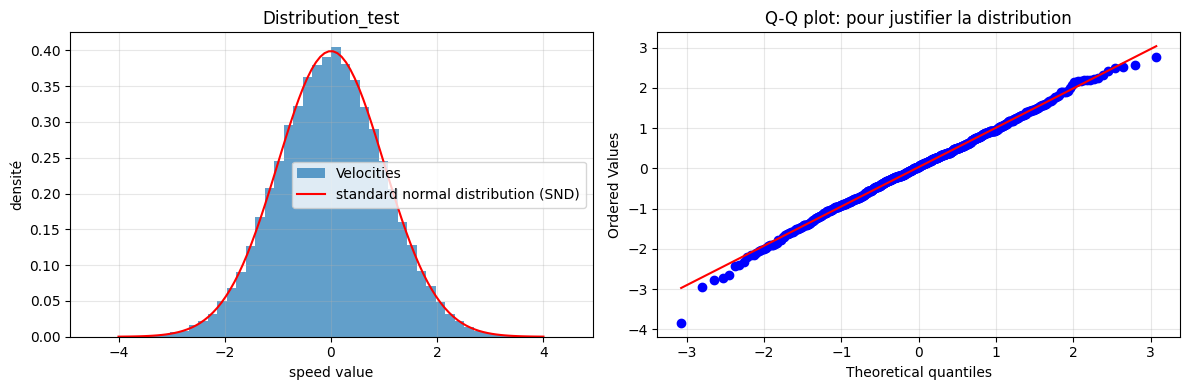


💾 Données améliorées sauvegardées: training_pairs_augmented.npy

🔄 验证保存的数据...
重新加载形状: (496, 2, 22, 6)
数据类型: float32


In [ ]:
#Test si on peut utiliser Training_pairs.npy
import numpy as np
import matplotlib.pyplot as plt

pairs_array = np.load("training_pairs.npy", allow_pickle=True)
print(f"Forme: {pairs_array.shape}")

#Squeeze
pairs_array = np.squeeze(pairs_array)
print(f"Forme Après Squeeze: {pairs_array.shape}")

assert pairs_array.shape == (496, 2, 22, 3)
print("Ok")

if pairs_array.shape[1:] != (2, 22, 3):
   print("Formule incorrecte!")
   exit()

N_pairs, _, n_atoms, n_dims = pairs_array.shape
print(f"Formule correcte avec {N_pairs}training_pairs, {n_atoms}atomes, {n_dims}dims")

#Add the velocities
print("Standard: x^v(t) ~ N(0, I) - Independent Gaussian noise")
#Origine: (N_pairs, 2, n_atoms, 3) - seulement des positions
#But: (N_pairs, 2, n_atoms, 6) - positions+vitesse

np.random.seed(42)
auxiliary_velocities = np.random.normal(0, 1, size=(N_pairs, 2, n_atoms, 3)).astype(np.float32)

print(f"Generated auxiliary velocity shapes: {auxiliary_velocities.shape}")
print(f"Speed statistics: mean={auxiliary_velocities.mean():.4f}, std={auxiliary_velocities.std():.4f}")

#Combiner des positions et vitesses
augmented_pairs = np.concatenate([pairs_array, auxiliary_velocities], axis=-1)

print(f"\n Après renforcement: {augmented_pairs.shape}")


#Test again
sample_pair = augmented_pairs[0]
x_t = sample_pair[0]
x_t_tau = sample_pair[1]

print(f"Single point in time shape: {x_t.shape}")
print(f"Partie des positions: {x_t[:3, :3]}")
print(f"Partie des vitesses: {x_t[:3, 3:]}")

positions = augmented_pairs[:, :, :, :3]  # 位置
velocities = augmented_pairs[:, :, :, 3:]  # 速度

print(f"\n data statistics:")
print(f"Positions range: [{positions.min():.2f}, {positions.max():.2f}]")
print(f"Velocities range: [{velocities.min():.2f}, {velocities.max():.2f}]")
print(f"Velocities mean: {velocities.mean():.4f} (environ 0)")
print(f"Velocities ecart-type: {velocities.std():.4f} (environ 1)")

#Visualisation
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

velocities_flat = velocities.flatten()
ax1.hist(velocities_flat, bins=50, alpha=0.7, density=True, label='Velocities')
x_range = np.linspace(-4, 4, 100)
ax1.plot(x_range, np.exp(-x_range**2/2)/np.sqrt(2*np.pi), 'r-', label='standard normal distribution (SND)')
ax1.set_xlabel('speed value')
ax1.set_ylabel('densité')
ax1.set_title('Distribution_test')
ax1.legend()
ax1.grid(True, alpha=0.3)

#Q-Q
from scipy import stats
stats.probplot(velocities_flat[::100], dist="norm", plot=ax2)
ax2.set_title('Q-Q plot: pour justifier la distribution')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 7. 保存增强数据
output_filename = "training_pairs_augmented.npy"
np.save(output_filename, augmented_pairs)
print(f"\n💾 Données améliorées sauvegardées: {output_filename}")

# 8. 验证保存的数据
print("\n🔄 验证保存的数据...")
loaded_augmented = np.load(output_filename)
print(f"重新加载形状: {loaded_augmented.shape}")
print(f"数据类型: {loaded_augmented.dtype}")

In [ ]:
def get_positions_and_velocities(augmented_data, pair_idx):
    pair = augmented_data[pair_idx]

    pos_t = pair[0, :, :3]      # t时刻位置
    vel_t = pair[0, :, 3:]      # t时刻速度
    pos_t_tau = pair[1, :, :3]  # t+τ时刻位置
    vel_t_tau = pair[1, :, 3:]  # t+τ时刻速度

    return pos_t, vel_t, pos_t_tau, vel_t_tau

# 测试访问函数
pos_t, vel_t, pos_t_tau, vel_t_tau = get_positions_and_velocities(augmented_pairs, 0)
print(f"Forme de position en t: {pos_t.shape}, Forme de vitesse en t: {vel_t.shape}")
print(f"Forme de position en t+tau: {pos_t_tau.shape}, Forme de vitesse en t+tau: {vel_t_tau.shape}")

Forme de position en t: (22, 3), Forme de vitesse en t: (22, 3)
Forme de position en t+tau: (22, 3), Forme de vitesse en t+tau: (22, 3)
